Stock Prediction AI
by Boris Banushev

Edited by: Tuege Neumann
Created: 14th October 2022

https://github.com/borisbanushev/stockpredictionai

In [178]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [6]:
dataset_ex_df = pd.read_csv('C:/Users/tuege/Downloads/GS.csv', header=0, parse_dates=[0], date_parser=parser)

In [7]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2009-12-31,168.839996
1,2010-01-04,173.080002
2,2010-01-05,176.139999


	Date	GS
0	2009-12-31	168.839996
1	2010-01-04	173.080002
2	2010-01-05	176.139999

In [8]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2265 number of days in the dataset.


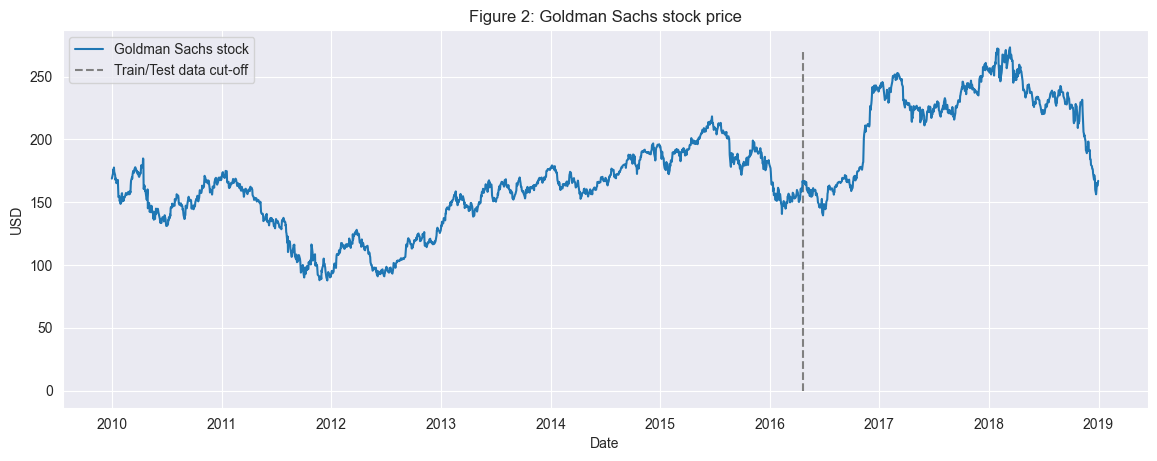

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [10]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1585. Number of test days: 680.


In [11]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = pd.DataFrame.ewm(dataset['Close'], span=26).mean()
    dataset['12ema'] = pd.DataFrame.ewm(dataset['Close'], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['log_momentum'] = np.log(dataset['Close']-1)

    return dataset

In [12]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [13]:
dataset_TI_df=dataset_TI_df[:][20:]
dataset_TI_df

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,log_momentum
20,2010-02-01,149.820007,155.250000,149.210007,153.130005,125.444969,12980800,152.374285,164.220476,160.321839,156.655072,-3.666767,9.607375,183.435226,145.005726,152.113609,5.024735
21,2010-02-02,153.649994,157.500000,153.649994,156.940002,128.566101,17246600,152.777143,163.653809,160.014868,156.700047,-3.314821,9.480630,182.615070,144.692549,155.331204,5.049471
22,2010-02-03,157.919998,159.940002,157.110001,157.229996,128.803696,16785200,153.098572,162.899047,159.766235,156.783365,-2.982871,9.053702,181.006450,144.791644,156.597065,5.051329
23,2010-02-04,155.270004,156.059998,150.449997,150.679993,123.437874,18895000,153.069999,161.686666,158.967168,155.827031,-3.140137,8.940246,179.567158,143.806174,152.652350,5.008500
24,2010-02-05,150.820007,154.460007,148.869995,154.160004,126.288750,18759200,153.449999,160.729523,158.550196,155.566566,-2.983631,8.151912,177.033348,144.425699,153.657453,5.031483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2018-12-24,159.000000,160.000000,154.309998,156.350006,144.168839,3783500,166.620002,179.774763,182.277728,170.924864,-11.352864,12.007080,203.788923,155.760603,158.564897,5.045681
2261,2018-12-26,157.000000,163.110001,151.699997,162.929993,150.236145,7054700,165.214286,178.528572,180.844563,169.694884,-11.149679,11.991685,202.511942,154.545201,161.474961,5.087164
2262,2018-12-27,160.119995,165.410004,159.020004,165.410004,152.522949,4973000,164.842859,177.150953,179.701262,169.035672,-10.665590,11.677966,200.506885,153.795021,164.098323,5.102363
2263,2018-12-28,165.639999,165.949997,162.020004,163.029999,150.328400,4110500,163.632858,175.692858,178.466354,168.111722,-10.354632,10.810508,197.313874,154.071842,163.386107,5.087781


In [14]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

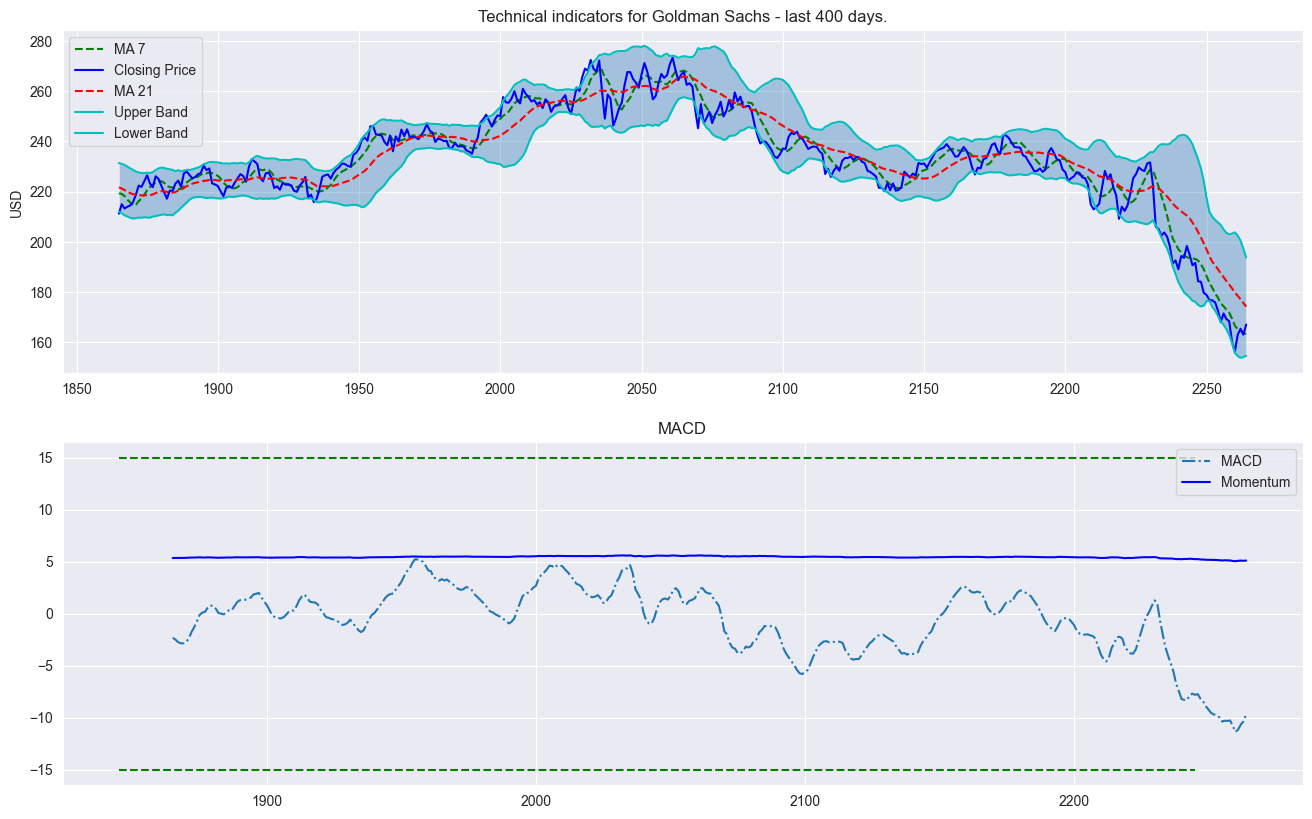

In [15]:
plot_technical_indicators(dataset_TI_df, 400)

In [16]:
# just import bert
import bert

In [17]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [18]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

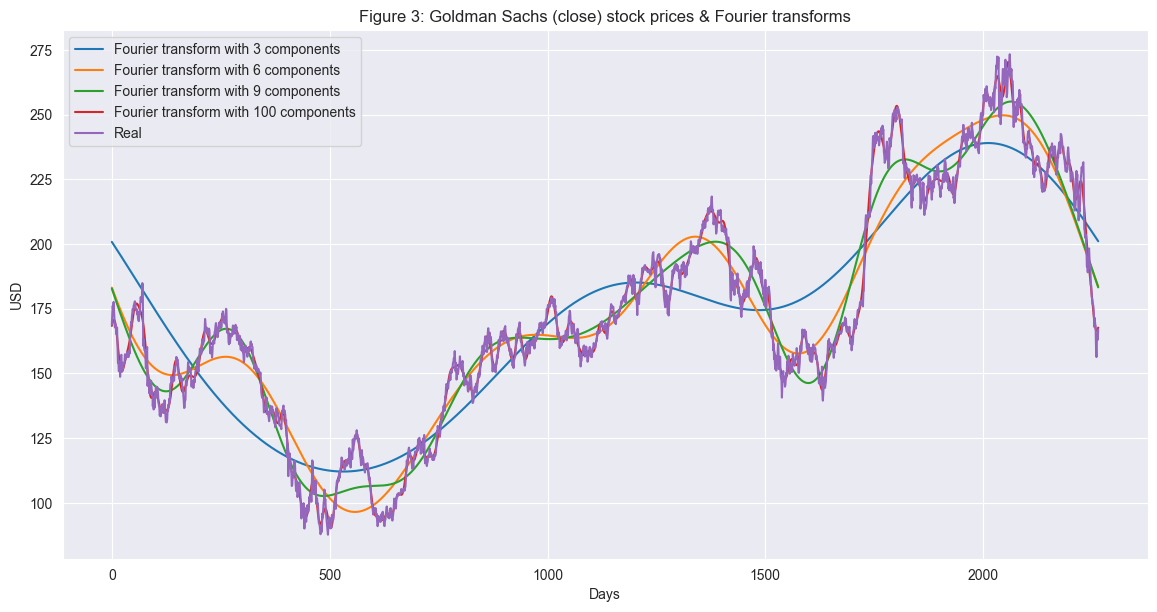

In [19]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [20]:
np.fft.ifft(fft_list_m10)

array([168.39287669+0.11515908j, 169.08513606+0.13264114j,
       169.72842521+0.13998141j, ..., 166.69353196+0.01844151j,
       167.13332255+0.05578956j, 167.72007982+0.08887191j])

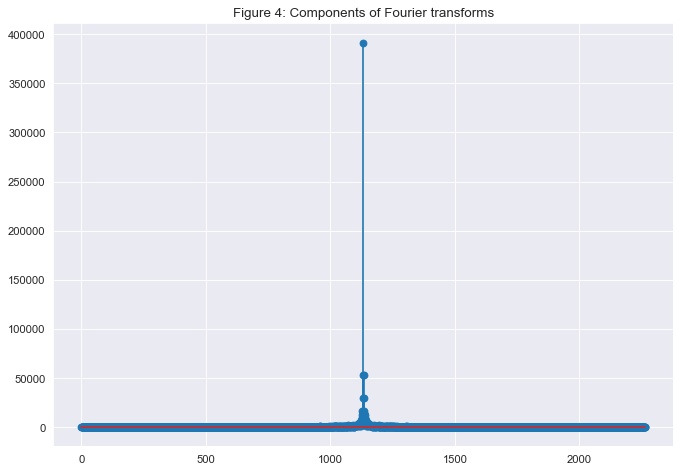

In [21]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

Period Range: ~880us to ~885us
Period Peak: 883us (1.132kHz) = 0.000888339222

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5465.888
Method:                       css-mle   S.D. of innovations              2.706
Date:                Mon, 24 Oct 2022   AIC                          10945.777
Time:                        01:55:48   BIC                          10985.851
Sample:                             1   HQIC                         10960.399
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.054     -0.020      0.984      -0.106       0.104
ar.L1.D.Close    -0.0205      0.021     -0.974      0.330      -0.062       0.021
ar.L2.D.Close     0.0140      0.021     

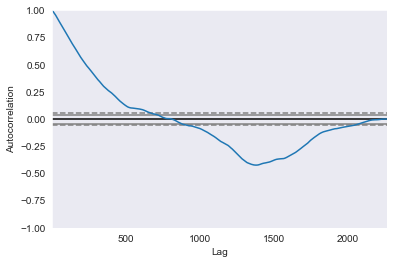

<Figure size 800x560 with 0 Axes>

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

Features Generated

Correlated Assets: 7
Technical Indicators: 10
Fundamental Analysis:
Fourier Transform: 4
ARIMA: 56
 Total: 112

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_ex_df.shape[0], \
                                                              dataset_ex_df.shape[1]))

Stock Indicators:
    simple moving average
    exponential moving average (time
    weighted moving average (time periods)

Types of indicator:
    Volume
    Volatility
    Momentum
    Trend

    MACD
    RSI
    CCI channel commodety index
    bollenger bands
    volume
    price volume chain
    volume weighted average price
    stochastic indicator
    super trend
    ATR average true range
    open interest
    fibonachi retracement
    average direction index
    on balance volume indicator
    correlation coefficient
    Aroon
    money flow index
    PSAR Parabolic Sar indicator
    ADX
    percentage price oscillator
    standard deviation indicator

Fundamental Analaysis Indicators:
     enterprise value over earnings

$$L(D, G) = \mathbb{E}{x \sim p{r}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log(1 - D(G(z)))]$$

#$D_{KL}(p | q) = \int_x p(x) \log \frac{p(x)}{q(x)} dx$

$D_{JS}(p | q) = \frac{1}{2} D_{KL}(p | \frac{p + q}{2}) + \frac{1}{2} D_{KL}(q | \frac{p + q}{2})$

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$

In [37]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]

    train_samples = int(X.shape[0] * 0.65)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]

    return (X_train, y_train), (X_test, y_test)

In [162]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)
#print(dataset_TI_df[dataset_TI_df.columns])

In [163]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [164]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [165]:
eval_result = regressor.evals_result()

In [166]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

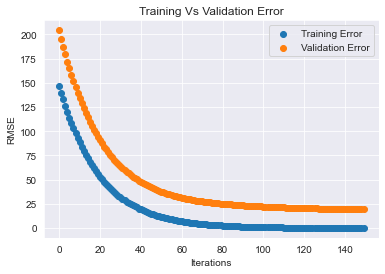

In [167]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

[7.59194081183523e-05, 0.005920993629842997, 0.007092024199664593, 0.9471842050552368, 0.003126757685095072, 2.6640293526725145e-06, 0.00022718924446962774, 9.669078281149268e-06, 2.2645244825980626e-05, 1.2754067029163707e-05, 2.878138275264064e-06, 2.763383918136242e-06, 9.767089795786887e-05, 7.860384357627481e-06, 0.03621407598257065, 0.0]


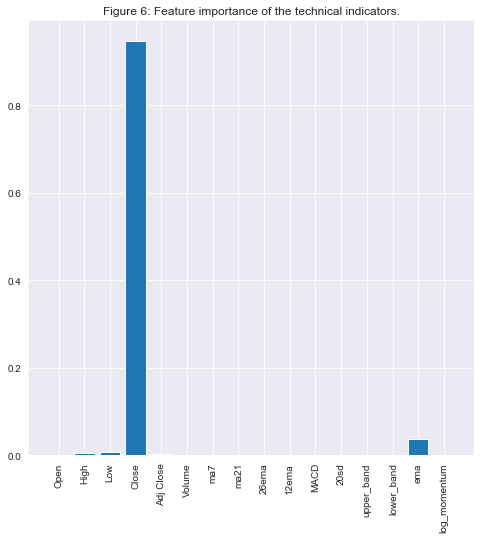

In [168]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
feature_importance_list = xgbModel.feature_importances_.tolist()
feature_importance_name = list(X_test_FI.columns)
#for n in range(5, -1, -1):
#    feature_importance_list.pop(n)
#    feature_importance_name.pop(n)
#    print(feature_importance_name)
plt.bar([i for i in range(len(feature_importance_list))], feature_importance_list, tick_label=feature_importance_name)
print(xgbModel.feature_importances_.tolist())
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [180]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

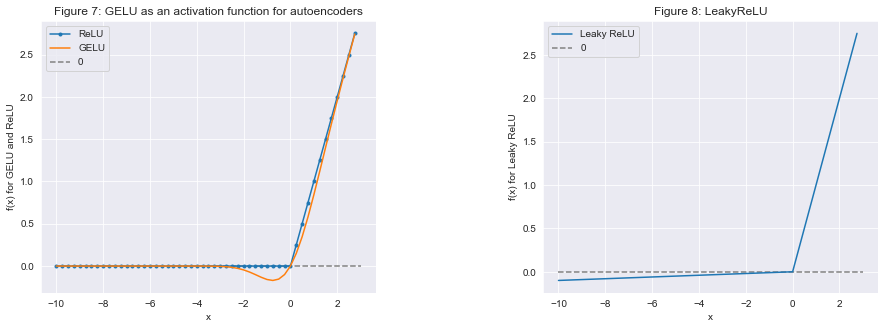

In [181]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [182]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

NameError: name 'VAE_data' is not defined

In [ ]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)

        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')

            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [ ]:
n_hidden=400 # neurons in each layer
n_latent=2
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='gelu')

In [ ]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [ ]:
print(net)

In [ ]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

In [ ]:
dataset_total_df['Date'] = dataset_ex_df['Date']

In [ ]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)

In [ ]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

In [173]:
gan_num_features = dataset_TI_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')

            self.decoder = nn.Dense(1, in_units=num_hidden)

    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

In [174]:
print(lstm_model)

RNNModel(
  (rnn): LSTM(17 -> 500, TNC)
  (decoder): Dense(500 -> 1, linear)
)


In [175]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction

    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs

    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length

        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

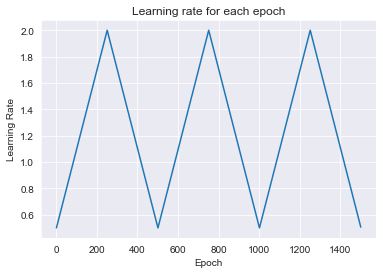

In [176]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500

plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)])
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [179]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():

    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())

    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))

# ... other parts of the GAN

AttributeError: module 'mxnet' has no attribute 'name_scope'